In [96]:
""" An added attribute of phase (dictionary). "t" is when the phase is installed, "index" is the how many array elements we shift based on
    the hilbert transform from the simulation. "index_theo" is the same but based on theoretical wave phase velocity.
    Usage:
        quantity = np.roll(quantity, -(idx), axis=0)
    where axis=0 corresponds to the x axis.    
"""

def extract_phase (case):    
    """ TODO: write the part that compare time from the pickle """
    
    picklename = case.path + 'eta/' + 'phase_info' +'.pkl'
    exists = os.path.exists(picklename)
    # If the pickle is there read in the pickles
    if exists:
        case.phase = load_object(picklename)
        print('pickle restored!')
    else:
        case.phase = {"t":[], "idx":[], "idx_theo":[], "eta":[]}
        for (j,t) in tqdm(enumerate(case.tsimu)):
            case.phase['t'].append(t-case.tstart)
            interface = Interface2D(L0 = case.L0, N = case.N, 
                                    path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)    
            # TODO: append other field in interface too
            case.phase['idx'].append(interface.idx)
            idx_theo = int(round(case.wave.c*(t-case.tstart)/(2*np.pi/case.k)*int(case.N/case.k)) % int(case.N/case.k))
            case.phase['idx_theo'].append(idx_theo)
            case.phase['eta'].append(interface.eta)

        """ Save the phsae dictionary"""
        save_object(case.phase, picklename)

case = case1
case.tstart = 57
case.tsimu = np.arange(58,108,1)
extract_phase(case)

case = case2
case.tstart = 57
case.tsimu = np.arange(58,94,1)
extract_phase(case)
case.tsimu = np.arange(58,94,1)

case = case3
case.tstart = 57
case.tsimu = np.arange(58,73,1)
extract_phase(case)

# case = case4
# case.tstart = 307
# case.tsimu = np.arange(308,345,1)

# case = case5
# case.tstart = 301.5
# case.tsimu = np.arange(302,342,1)

# case = case6
# case.tstart = 307
# case.tsimu = np.arange(308,320,1)

pickle restored!
pickle restored!
pickle restored!


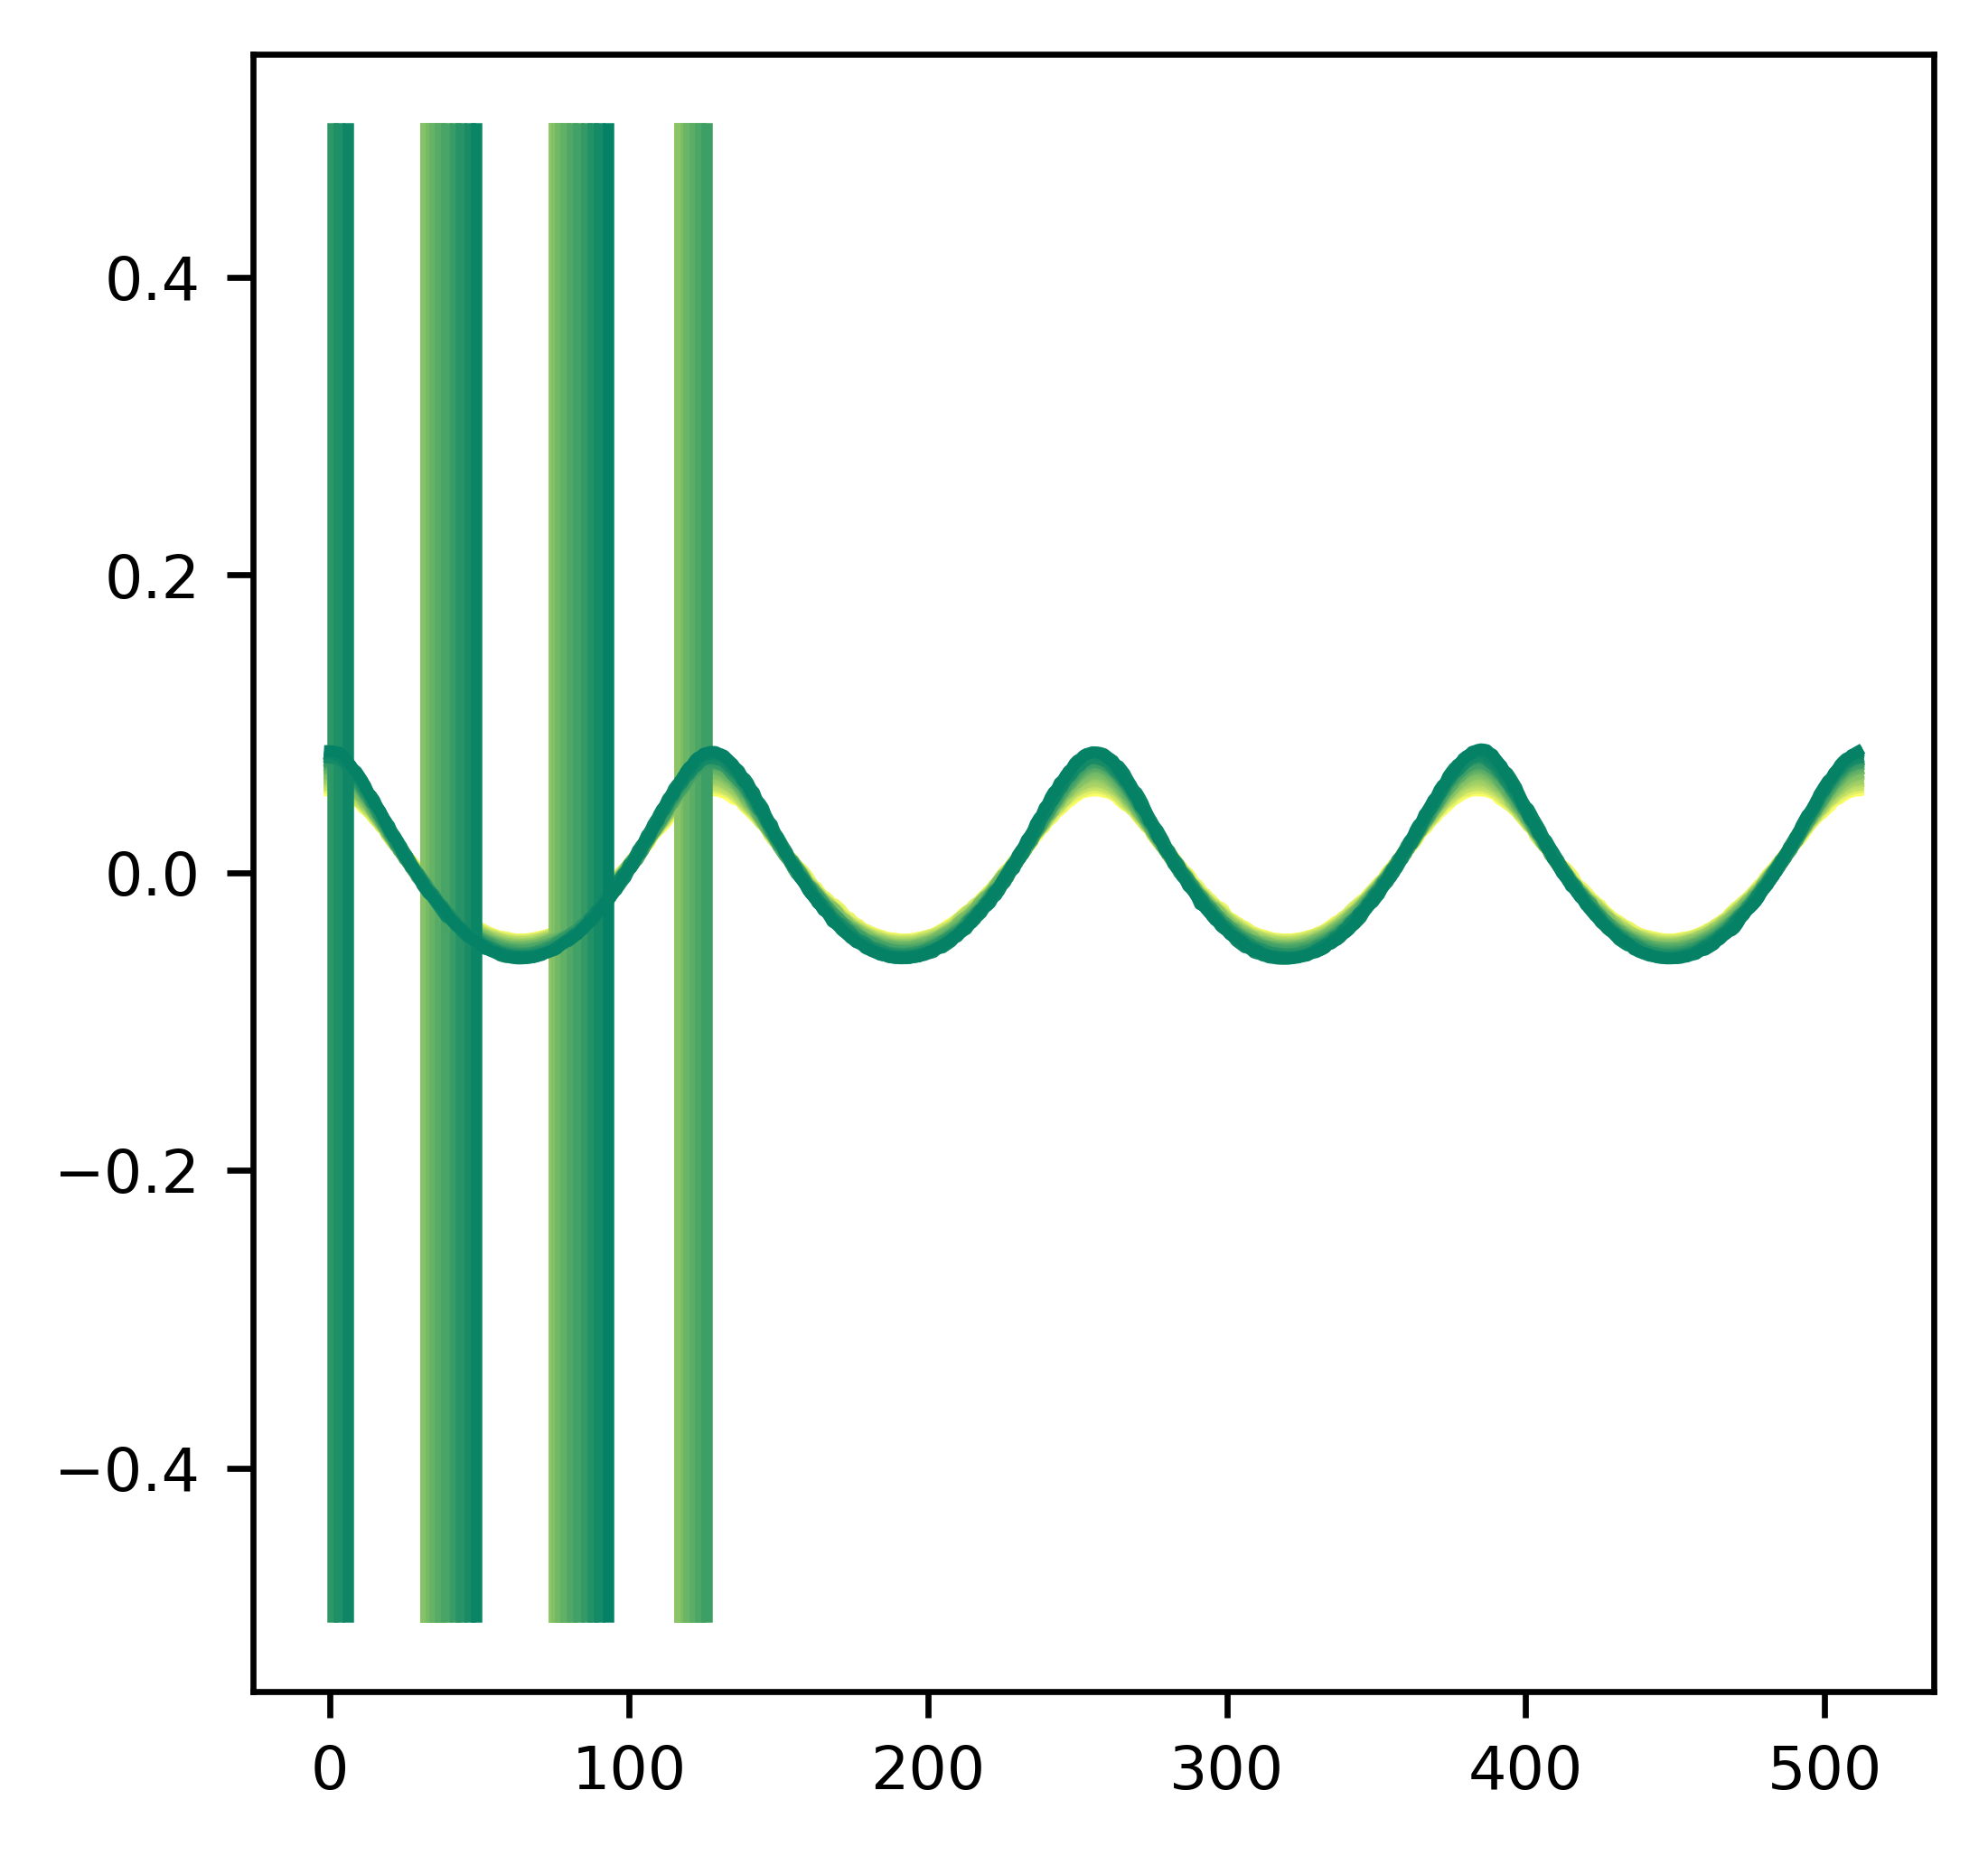

In [144]:
""" Check that the phase is computed correctly
    We can later add wave phase computation to this.
"""
case = case1
for i in range(0,np.size(case.tsimu)):
#     plt.plot(np.average(case.phase['eta'][i], axis=0)-1, label='t=%g' %case.phase['t'][i], color=plt.cm.get_cmap('summer')(1-i/5))
#     plt.plot(np.roll(np.average(case.phase['eta'][i], axis=0), -int(case.phase['idx_theo'][i]), axis=0), label='t=%g' %case.phase['t'][i], color=plt.cm.get_cmap('summer')(1-i/10))
    plt.plot(np.roll(np.average(case.phase['eta'][i], axis=0)-1, -int(case.phase['idx'][i]), axis=0), label='t=%g' %case.phase['t'][i], color=plt.cm.get_cmap('summer')(1-i/np.size(case.tsimu)))
#     plt.plot(np.ones(10)*(case.phase['idx_theo'][i]+128/4), np.linspace(0.8,1.2,10), ':', color=plt.cm.get_cmap('summer')(1-i/10))
    plt.plot(np.ones(10)*(case.phase['idx'][i] % 128), np.linspace(-0.5,0.5,10), color=plt.cm.get_cmap('summer')(1-i/np.size(case.tsimu)))
# plt.legend()

Text(0, 0.5, '$\\phi (\\degree)$')

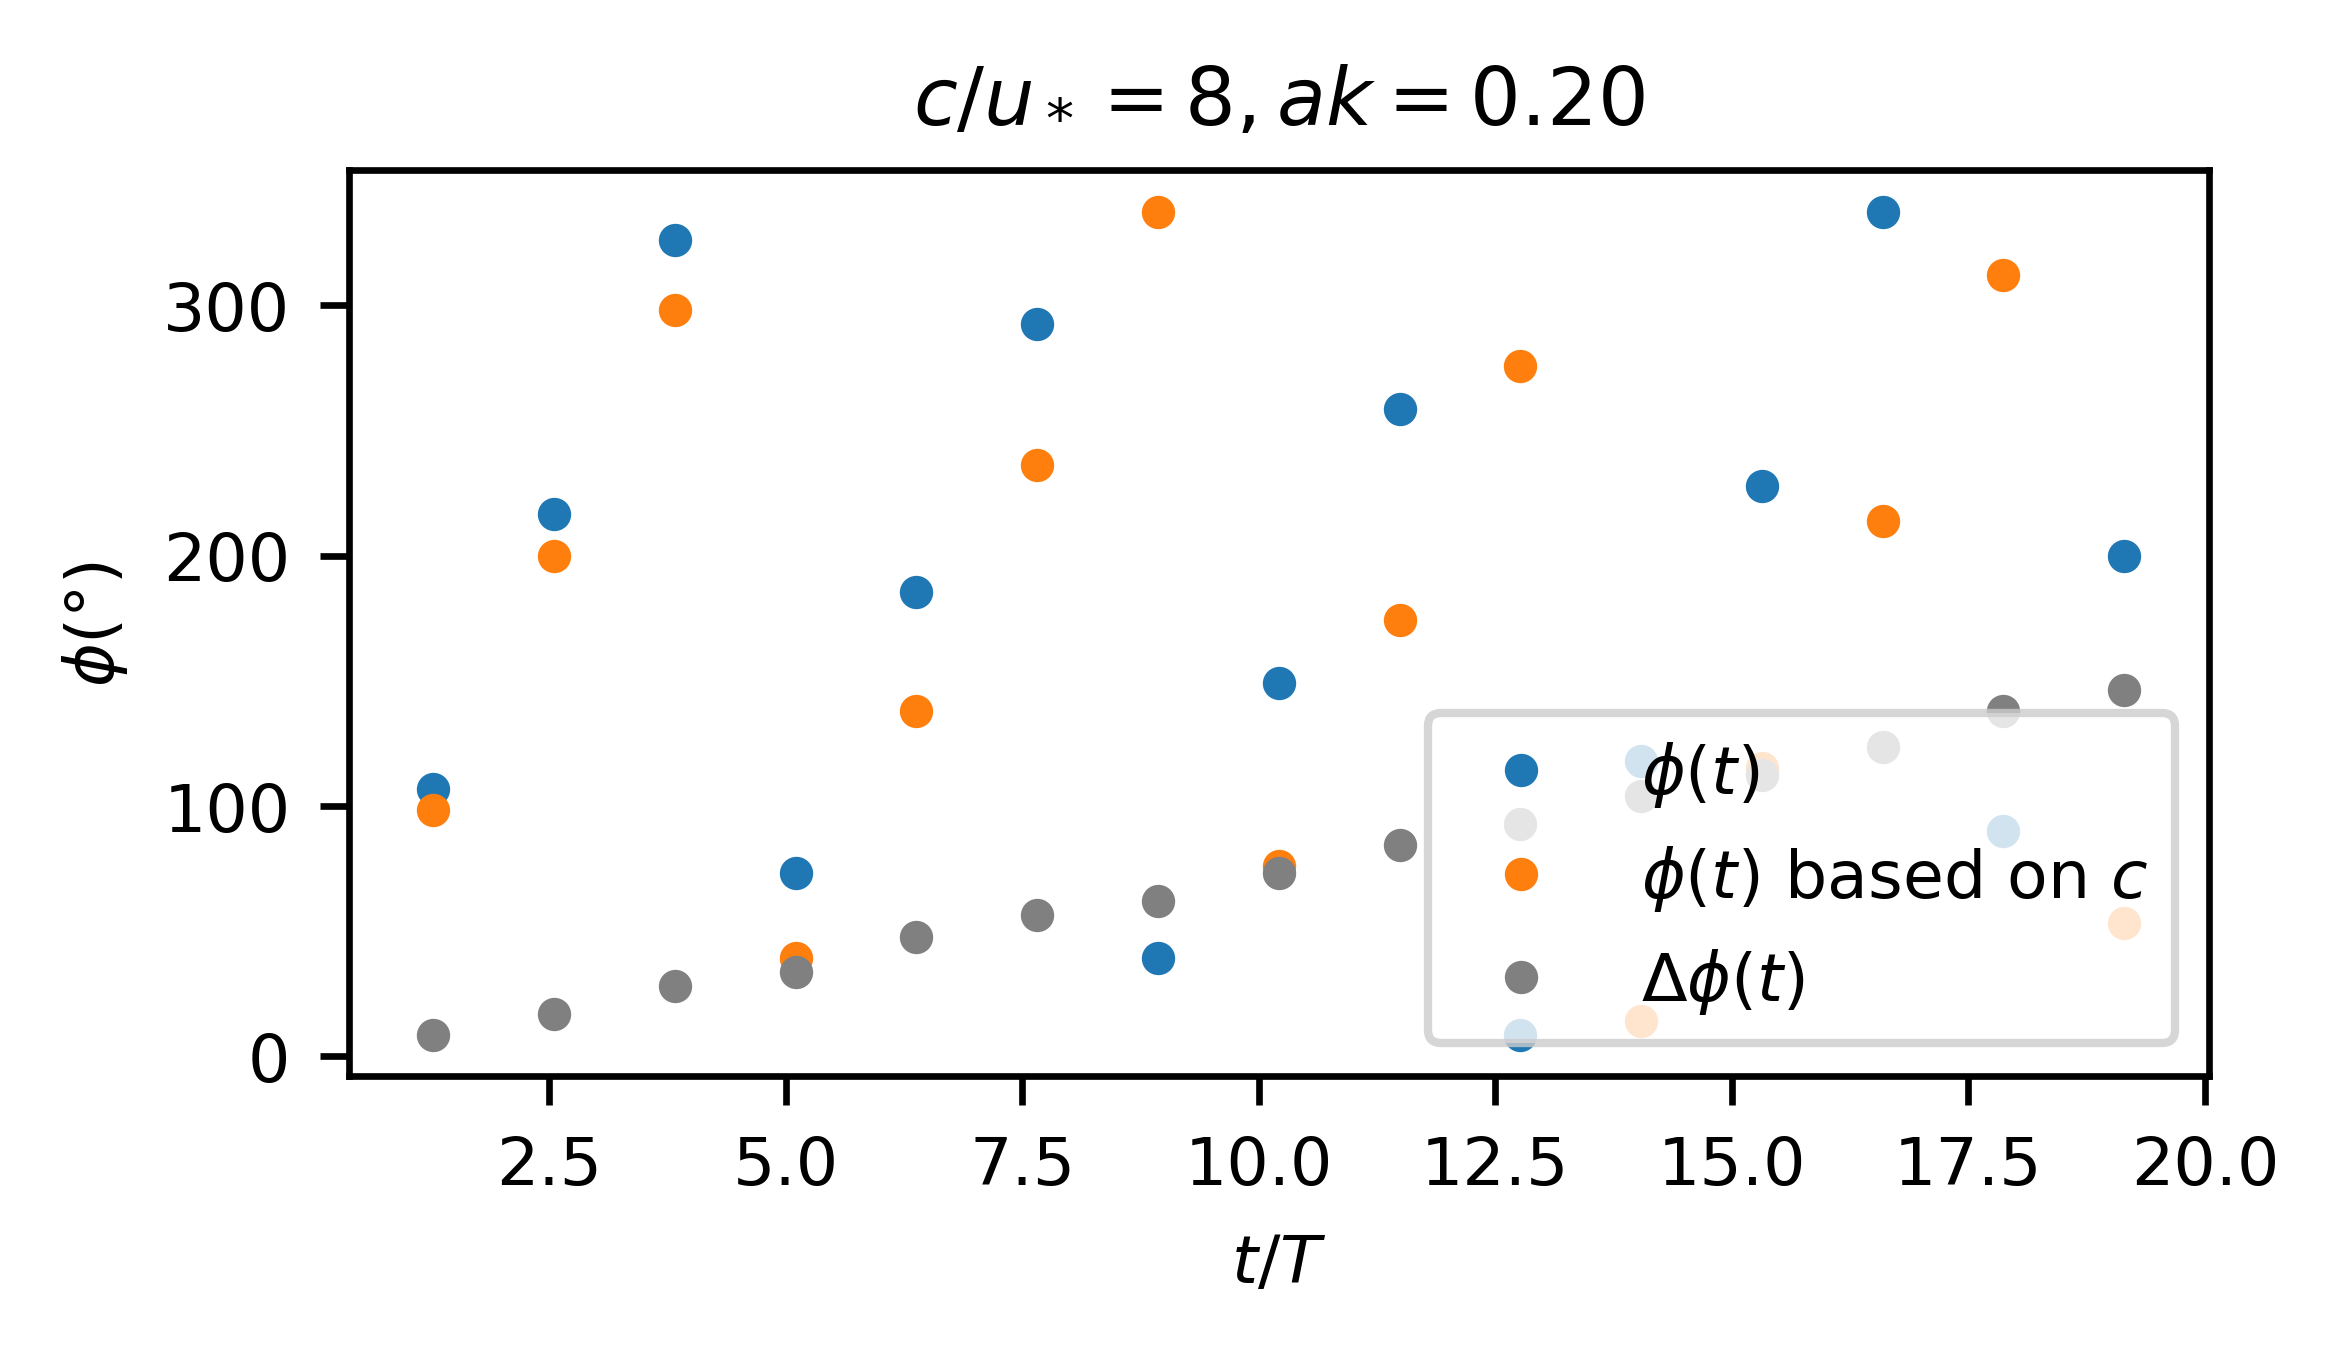

In [100]:
""" Compare phase to theoretical phase speed """
plt.figure(figsize=[4,2])
T = 2*np.pi/case.wave.omega
plt.plot(np.array(case.phase['t'])/T, (np.array(case.phase['idx']) % 128)/128*360, '.', label=r'$\phi(t)$')
plt.plot(np.array(case.phase['t'])/T, (np.array(case.phase['idx_theo']))/128*360, '.', label=r'$\phi(t)$ based on $c$')
plt.plot(np.array(case.phase['t'])/T, ((np.array(case.phase['idx']) % 128 - np.array(case.phase['idx_theo'])) % 128)/128*360, '.', color='gray', label=r'$\Delta \phi(t)$')
plt.legend(loc = 'lower right'); plt.title(r'$c/u_* = %.0f, ak = %.2f$' %(case.wave.c/case.ustar, case.ak))
plt.xlabel(r'$t/T$'); plt.ylabel(r'$\phi (\degree)$')

In [ ]:
"""Already knowing the phase at each time, align them"""
case.ux_2D = []
case.uy_2D = []
case.f_2D = []

for i in tqdm(range(4,np.size(case.tsimu))):
    
    NSLICE = 256    
    NGRID = 512
    ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
    uy_3D = {'name':'uy', 'value':[]}
    f_3D = {'name':'f', 'value':[]}
    tsimu = case.phase['t'][i] + case.tstart
    idx = case.phase['idx'][i]
    
    # Read in the fields either from pickle or from slice data
    for field in (ux_3D,uy_3D,f_3D):         
        """NOTICE: to accomodate different pickle versions"""
        picklename = case.path + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % tsimu +'.pkl'
#             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
        exists = os.path.exists(picklename)
        # If the pickle is there read in the pickles
        if exists:
            field['value'] = load_object(picklename)
            print('pickle restored!')
        # If no pickle read in from the slice files and pickle dump
        if not exists:
            for sn in range (0, NSLICE-1):
                filename = case.path + 'field/'+field['name']+'_t%g_slice%g' % (tsimu,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
            save_object(field['value'], picklename)
            
        # Shift the values along x axis
        field['value'] = np.roll(field['value'], -idx, axis=1)
    
    case.ux_2D.append(np.average(ux_3D['value'], axis=0))
    case.uy_2D.append(np.average(uy_3D['value'], axis=0))
    case.f_2D.append(np.average(f_3D['value'], axis=0))


  0%|          | 0/46 [00:00<?, ?it/s]

pickle restored!
pickle restored!
pickle restored!



  2%|▏         | 1/46 [00:04<03:03,  4.08s/it]

pickle restored!
pickle restored!
pickle restored!



  4%|▍         | 2/46 [00:08<02:58,  4.06s/it]

pickle restored!
pickle restored!
pickle restored!



  7%|▋         | 3/46 [00:12<03:01,  4.23s/it]

pickle restored!
pickle restored!
pickle restored!



  9%|▊         | 4/46 [00:19<03:26,  4.91s/it]

pickle restored!
pickle restored!
pickle restored!



 11%|█         | 5/46 [00:22<03:00,  4.40s/it]

pickle restored!
pickle restored!
pickle restored!



 13%|█▎        | 6/46 [00:29<03:29,  5.23s/it]

pickle restored!
pickle restored!
pickle restored!



 15%|█▌        | 7/46 [00:36<03:49,  5.88s/it]

pickle restored!
pickle restored!
pickle restored!



 17%|█▋        | 8/46 [00:47<04:41,  7.40s/it]

pickle restored!
pickle restored!
pickle restored!



 20%|█▉        | 9/46 [01:01<05:43,  9.28s/it]

pickle restored!
pickle restored!
pickle restored!



 22%|██▏       | 10/46 [01:05<04:41,  7.81s/it]

pickle restored!
pickle restored!
pickle restored!



 24%|██▍       | 11/46 [01:33<07:57, 13.64s/it]

pickle restored!
pickle restored!
pickle restored!



 26%|██▌       | 12/46 [01:51<08:35, 15.17s/it]

pickle restored!
pickle restored!
pickle restored!



 28%|██▊       | 13/46 [02:02<07:37, 13.86s/it]

pickle restored!
pickle restored!
pickle restored!



 30%|███       | 14/46 [02:19<07:53, 14.79s/it]

pickle restored!
pickle restored!
pickle restored!



 33%|███▎      | 15/46 [02:26<06:24, 12.40s/it]

pickle restored!
pickle restored!
pickle restored!



 35%|███▍      | 16/46 [02:34<05:34, 11.14s/it]

pickle restored!
pickle restored!
pickle restored!



 37%|███▋      | 17/46 [02:38<04:21,  9.03s/it]

pickle restored!
pickle restored!
pickle restored!



 39%|███▉      | 18/46 [02:42<03:27,  7.42s/it]

pickle restored!
pickle restored!
pickle restored!



 41%|████▏     | 19/46 [02:45<02:45,  6.13s/it]

pickle restored!
pickle restored!
pickle restored!



 43%|████▎     | 20/46 [02:58<03:35,  8.28s/it]

pickle restored!
pickle restored!
pickle restored!



 46%|████▌     | 21/46 [03:07<03:28,  8.35s/it]

pickle restored!
pickle restored!
pickle restored!



 48%|████▊     | 22/46 [03:15<03:16,  8.18s/it]

pickle restored!
pickle restored!
pickle restored!



 59%|█████▊    | 27/46 [15:54<46:17, 146.16s/it]

In [118]:
np.size(case.tsimu)
np.size(case.phase['t'])
len(case.ux_2D)

11

In [309]:
case3.wave.omega

8.019975062305368

In [308]:
0.5*0.25*4/case3.wave.omega

0.06234433350672706








  0%|          | 0/11 [00:00<?, ?it/s]






100%|██████████| 11/11 [00:00<00:00, 150.35it/s]

Text(0, 0.5, '$yk$')

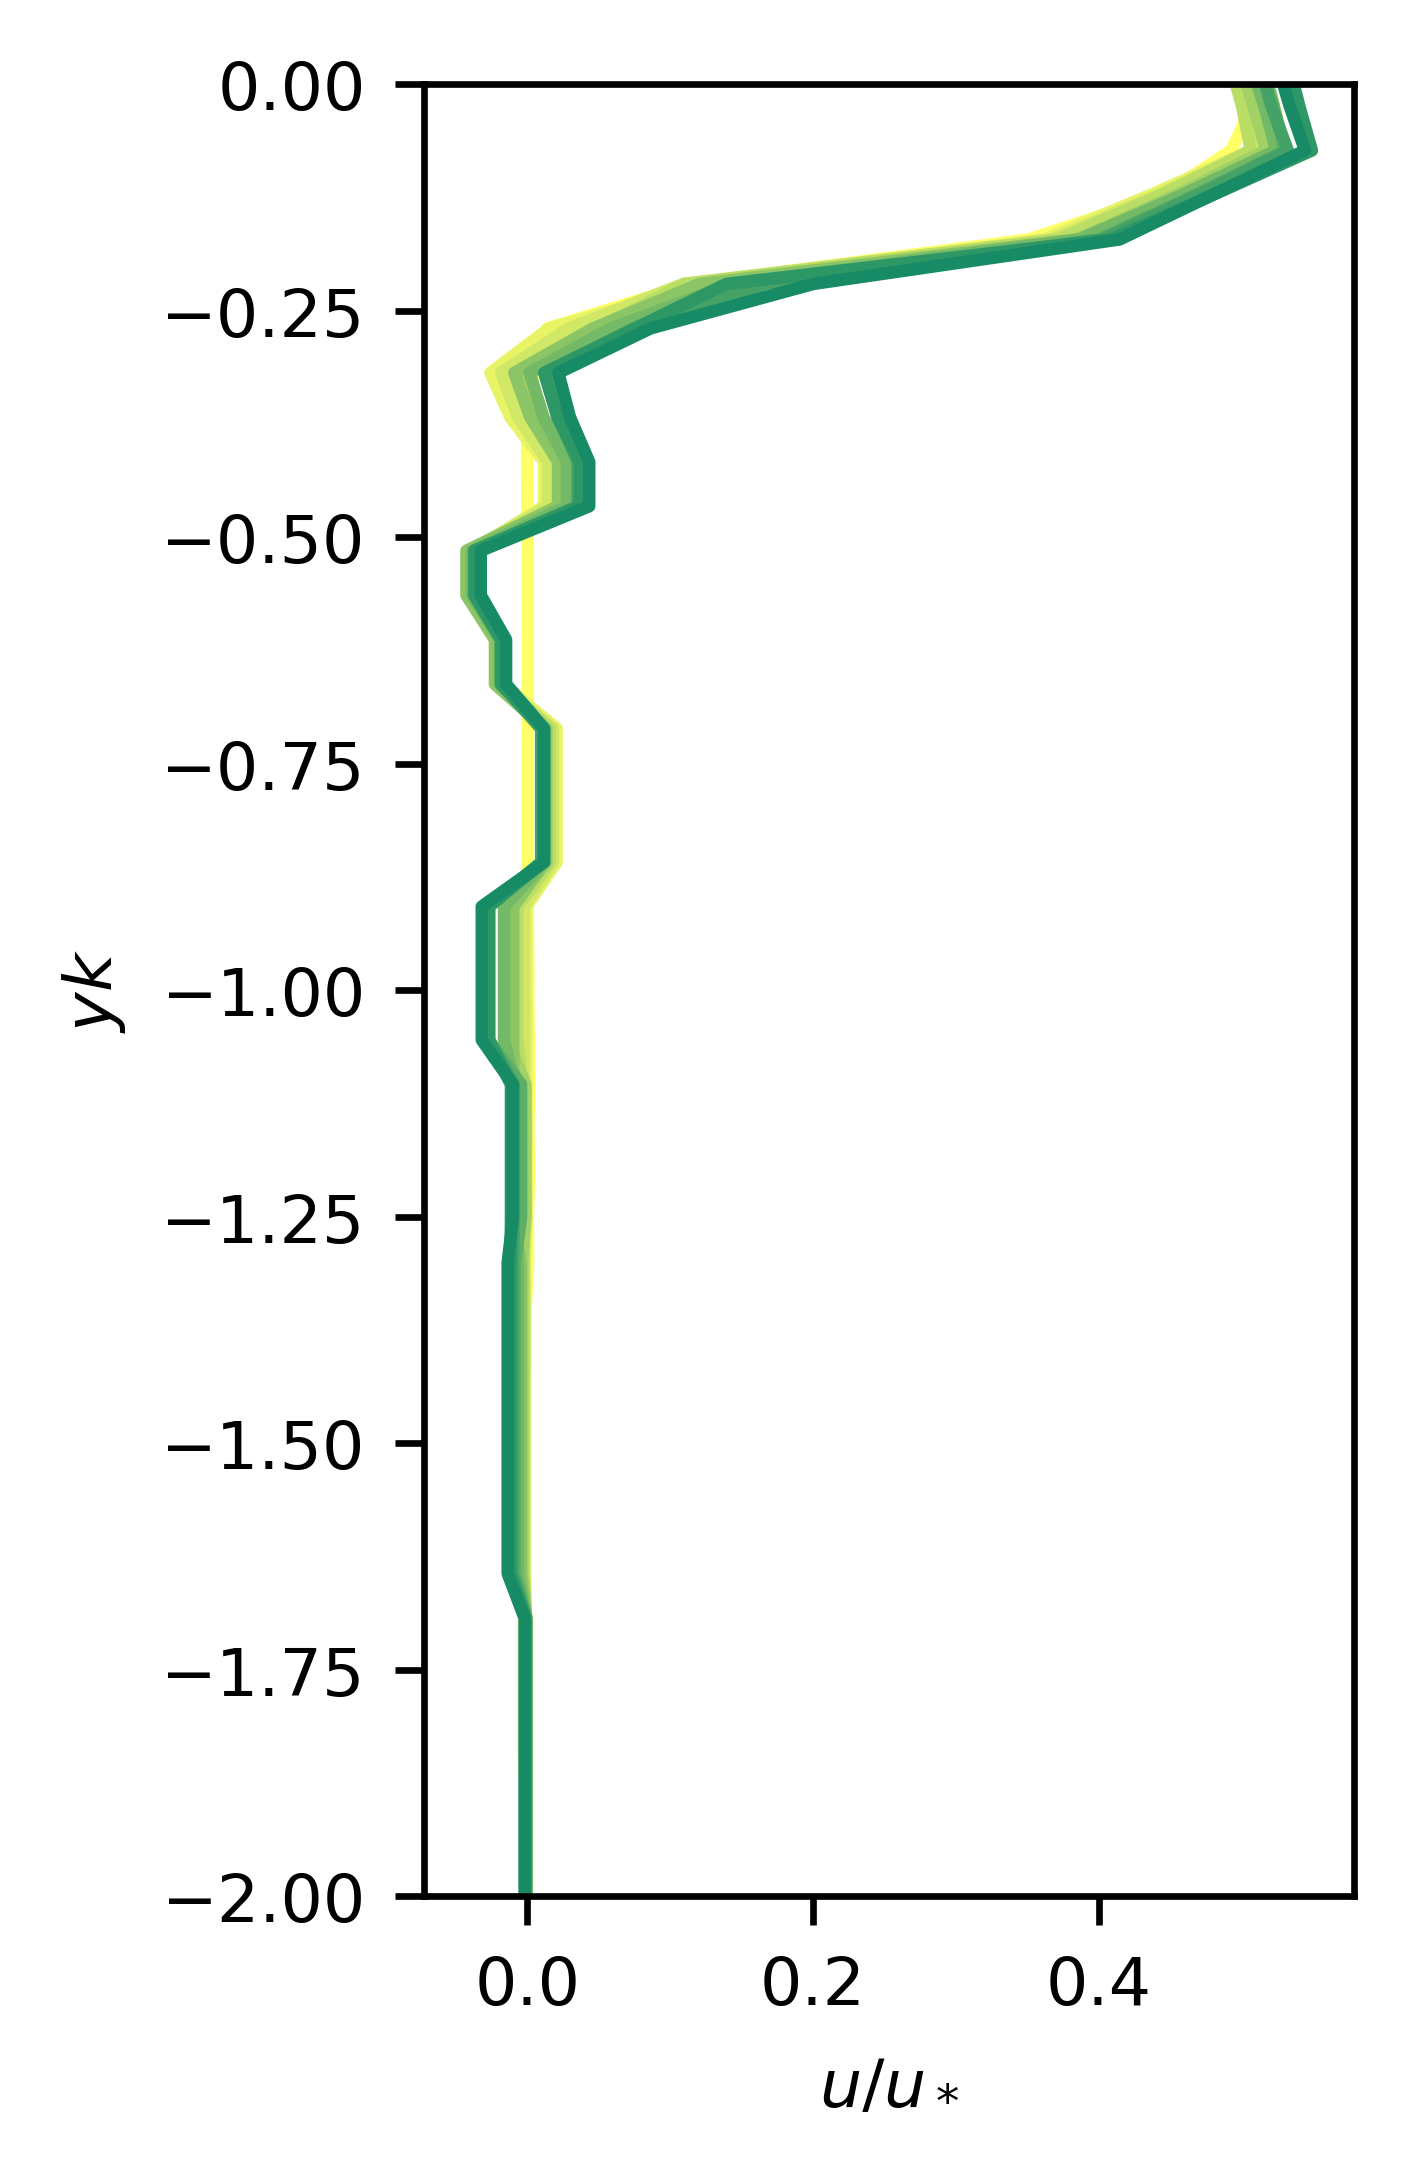

In [313]:
plt.figure(figsize=[2,4])
case = case3
case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2
for i in tqdm(range(len(case.ux_2D))):
    u_1D = np.average(case.ux_2D[i]*case.f_2D[i]**10, axis=0)
    plt.plot(u_1D/case.ustar, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/len(case.ux_2D)))
plt.ylim([-2,0])
plt.xlabel(r'$u/u_*$'); plt.ylabel(r'$yk$')

In [42]:
""" Compute the phase average and the horizontal average. 
    case.uy_2D_phaseaver-case.uy_2D_horizaver is the wave coherent part.
    case.field_2D is of dimension time*Nx*Nz
    case.field_2D_phaseaver and case.field_2D_horizaver is of dimension Nx*Ny
"""

case.ux_2D = np.array(case.ux_2D)
case.uy_2D = np.array(case.uy_2D)
case.f_2D = np.array(case.f_2D)

""" Phase average """
case.ux_2D_phaseaver = np.average(case.ux_2D, axis=0) 
case.uy_2D_phaseaver = np.average(case.uy_2D, axis=0)
case.f_2D_phaseaver = np.average(case.f_2D, axis=0)

""" Average over x and then broadcase to a 2D array again.
    TODO: Can add wave cordinate following average here.
"""
case.ux_2D_horizaver = np.tile(np.average(case.ux_2D, axis=(0,1)), (512,1))
case.uy_2D_horizaver = np.tile(np.average(case.uy_2D, axis=(0,1)), (512,1))
case.f_2D_horizaver = np.tile(np.average(case.f_2D, axis=(0,1)), (512,1))

In [43]:
""" Compute the turbulent stress. 
    Use the value of ux_2D_phaseaver and uy_2D_phaseaver computed above (broadcasted back to 3D).
'"""

case.uxuy_2D = []
ux_3D_phaseaver = np.tile(case.ux_2D_phaseaver, (255,1,1))
uy_3D_phaseaver = np.tile(case.uy_2D_phaseaver, (255,1,1))

for i in tqdm(range(4,np.size(case.tsimu))):
    
    ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
    uy_3D = {'name':'uy', 'value':[]}
    f_3D = {'name':'f', 'value':[]}
    tsimu = case.phase['t'][i] + case.tstart
    idx = case.phase['idx'][i]
    
    # Read in the fields either from pickle or from slice data
    for field in (ux_3D,uy_3D,f_3D):         
        """NOTICE: to accomodate different pickle versions"""
        picklename = case.path + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % tsimu +'.pkl'
#             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
        exists = os.path.exists(picklename)
        # If the pickle is there read in the pickles
        if exists:
            field['value'] = load_object(picklename)
            print('pickle restored!')
        # If no pickle read in from the slice files and pickle dump
        if not exists:
            for sn in range (0, NSLICE-1):
                filename = case.path + 'field/'+field['name']+'_t%g_slice%g' % (tsimu,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
            save_object(field['value'], picklename)
    
    re_stress_3D = (ux_3D['value']-ux_3D_phaseaver)*(uy_3D['value']-uy_3D_phaseaver)*(1-f_3D['value'])
    re_stress_3D = np.roll(re_stress_3D, -idx, axis=1)   
    case.uxuy_2D.append(np.average(re_stress_3D, axis=0))

  0%|          | 0/11 [00:00<?, ?it/s]

pickle restored!
pickle restored!
pickle restored!


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]

pickle restored!
pickle restored!
pickle restored!


 18%|█▊        | 2/11 [00:17<01:08,  7.58s/it]

pickle restored!
pickle restored!
pickle restored!


 27%|██▋       | 3/11 [00:23<00:57,  7.24s/it]

pickle restored!
pickle restored!
pickle restored!


 36%|███▋      | 4/11 [00:30<00:50,  7.23s/it]

pickle restored!
pickle restored!
pickle restored!


 45%|████▌     | 5/11 [00:36<00:39,  6.65s/it]

pickle restored!
pickle restored!
pickle restored!


 55%|█████▍    | 6/11 [00:43<00:34,  6.93s/it]

pickle restored!
pickle restored!
pickle restored!


 64%|██████▎   | 7/11 [00:51<00:28,  7.08s/it]

pickle restored!
pickle restored!
pickle restored!


 73%|███████▎  | 8/11 [00:58<00:21,  7.03s/it]

pickle restored!
pickle restored!
pickle restored!


 82%|████████▏ | 9/11 [01:04<00:14,  7.01s/it]

pickle restored!
pickle restored!
pickle restored!


 91%|█████████ | 10/11 [01:11<00:06,  6.84s/it]

pickle restored!
pickle restored!
pickle restored!


100%|██████████| 11/11 [01:17<00:00,  6.64s/it]


In [44]:
""" Compute the phase average and the horizontal average. """
case.uxuy_2D = np.array(case.uxuy_2D)
case.uxuy_2D_phaseaver = np.average(case.uxuy_2D, axis=0)
case.uxuy_2D_horizaver = np.tile(np.average(case.uxuy_2D, axis=(0,1)), (512,1))

Text(0.5, 1.05, '$\\tilde{u}\\tilde{w}/u_{*}^2$')

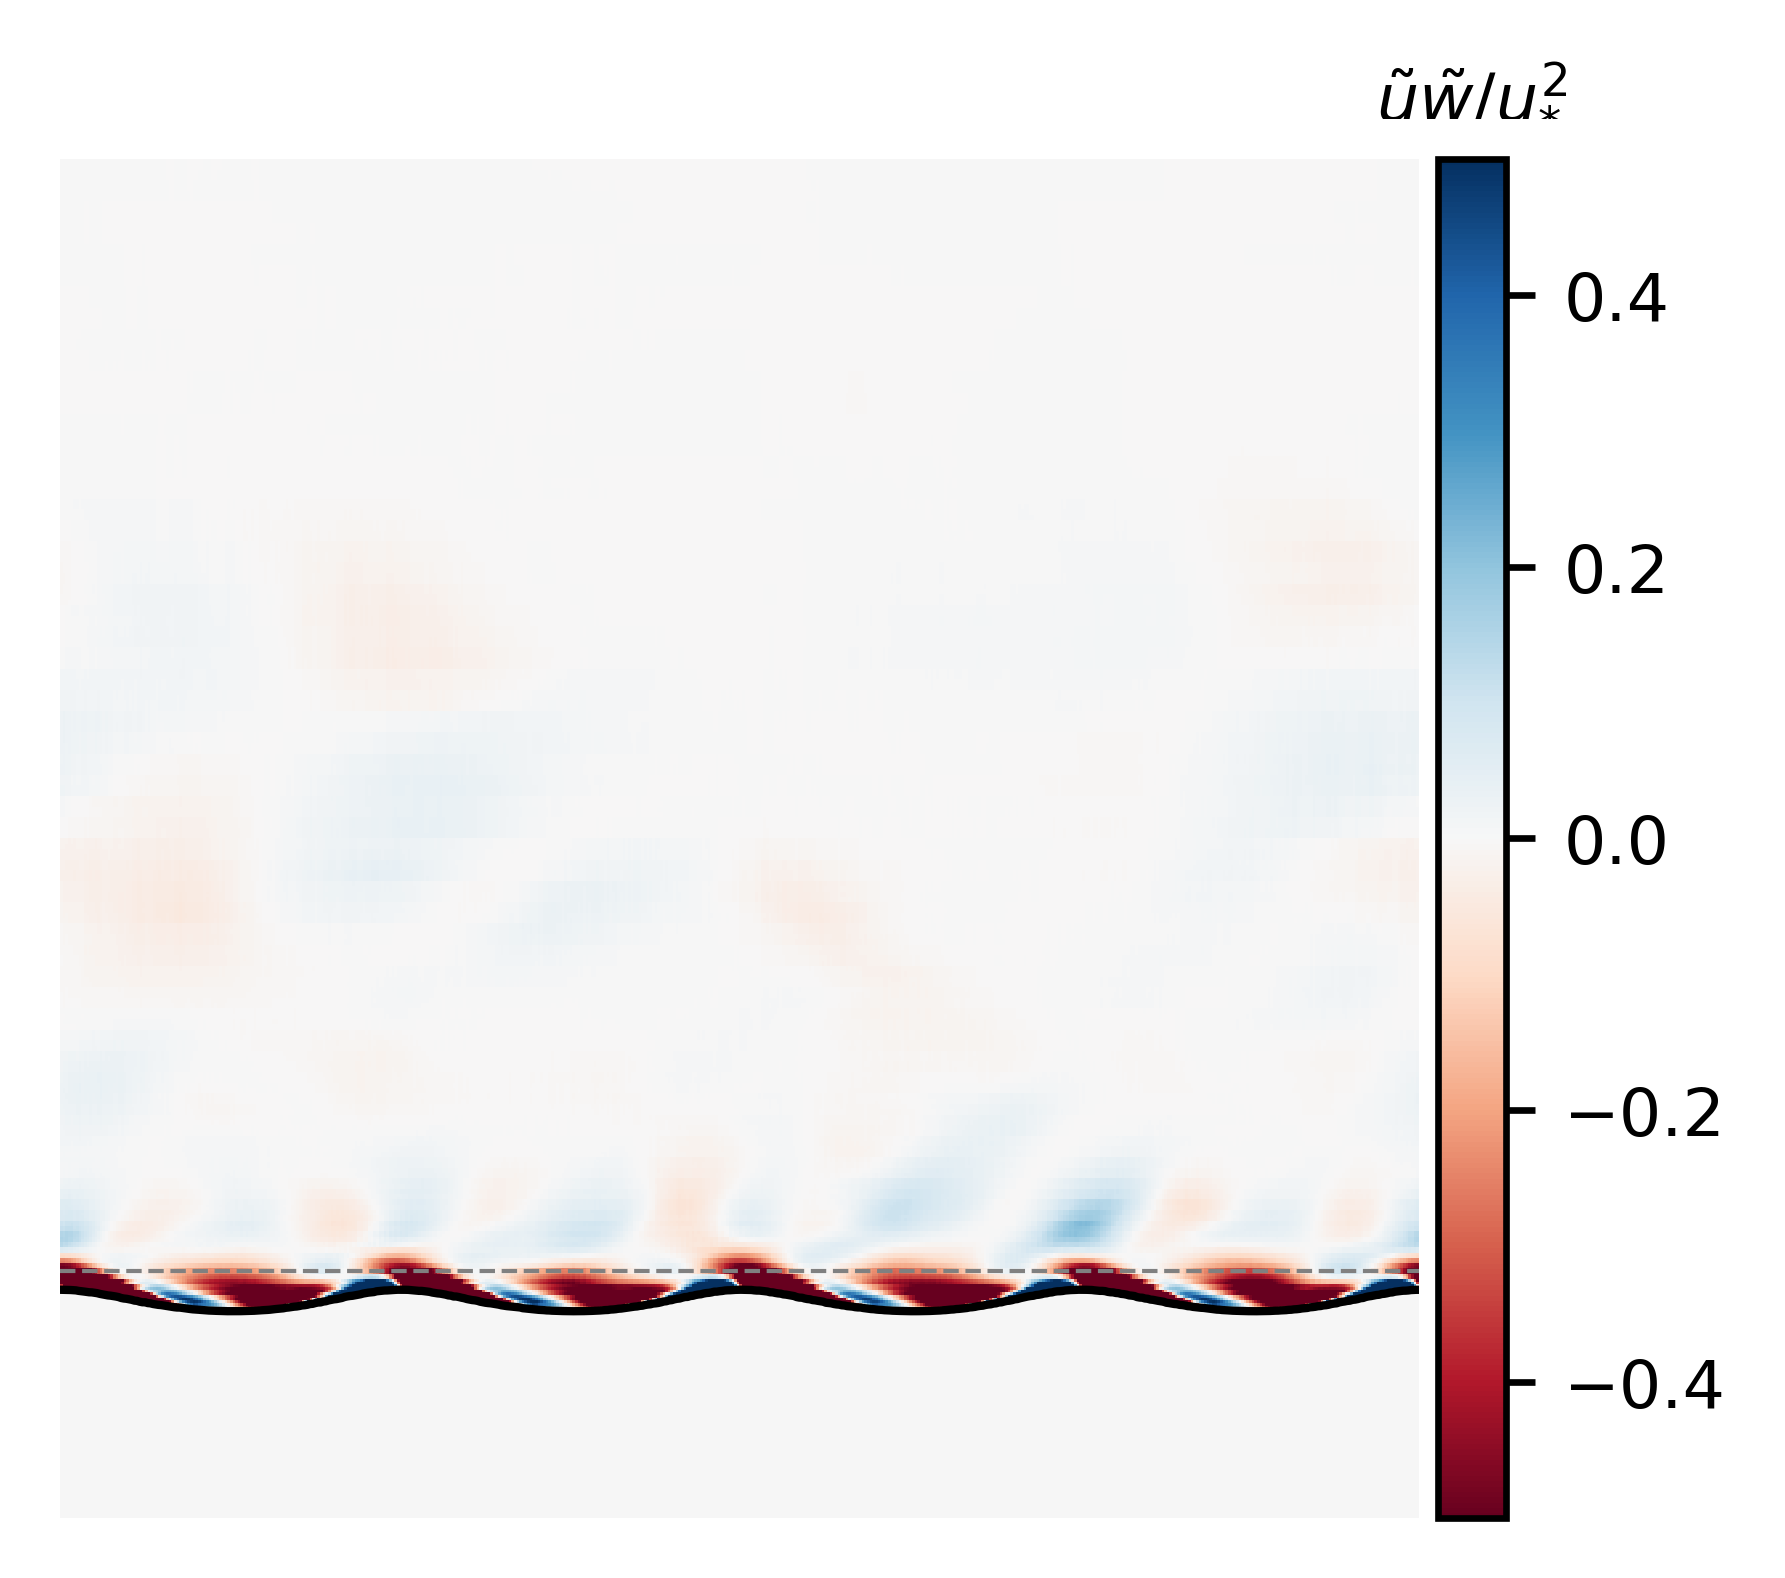

In [70]:
""" Some visualization """
fig = plt.figure(figsize=[4,3])
# quant = (case.uy_2D_phaseaver-case.uy_2D_horizaver)*(case.ux_2D_phaseaver-case.ux_2D_horizaver)/0.25**2*case.f_2D[0] # The quantity to be plotted
quant = (case.uy_2D_phaseaver-case.uy_2D_horizaver)*(case.ux_2D_phaseaver-case.ux_2D_horizaver)/0.25**2*(1-case.f_2D[0]) # The quantity to be plotted
# quant = (case.uxuy_2D_phaseaver-case.uxuy_2D_horizaver)/0.25**2

img = plt.imshow(np.rot90(quant), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = +0.5, vmin = -0.5)
xarray = np.linspace(-np.pi, np.pi, 512)
eta = np.roll(np.average(case.phase['eta'][0], axis=0), -case.phase['idx'][0], axis=0)
plt.plot(xarray, eta, c='k', lw=1)
plt.plot(xarray, 1.14*np.ones(np.size(xarray)), '--', lw=0.5, color='gray')
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\tilde{u}\tilde{w}/u_{*}^2$', ha='center', va='center', transform=cbar.ax.transAxes)

Text(0.5, 1.05, '$\\tilde{u}\\tilde{w}/u_{*}^2$')

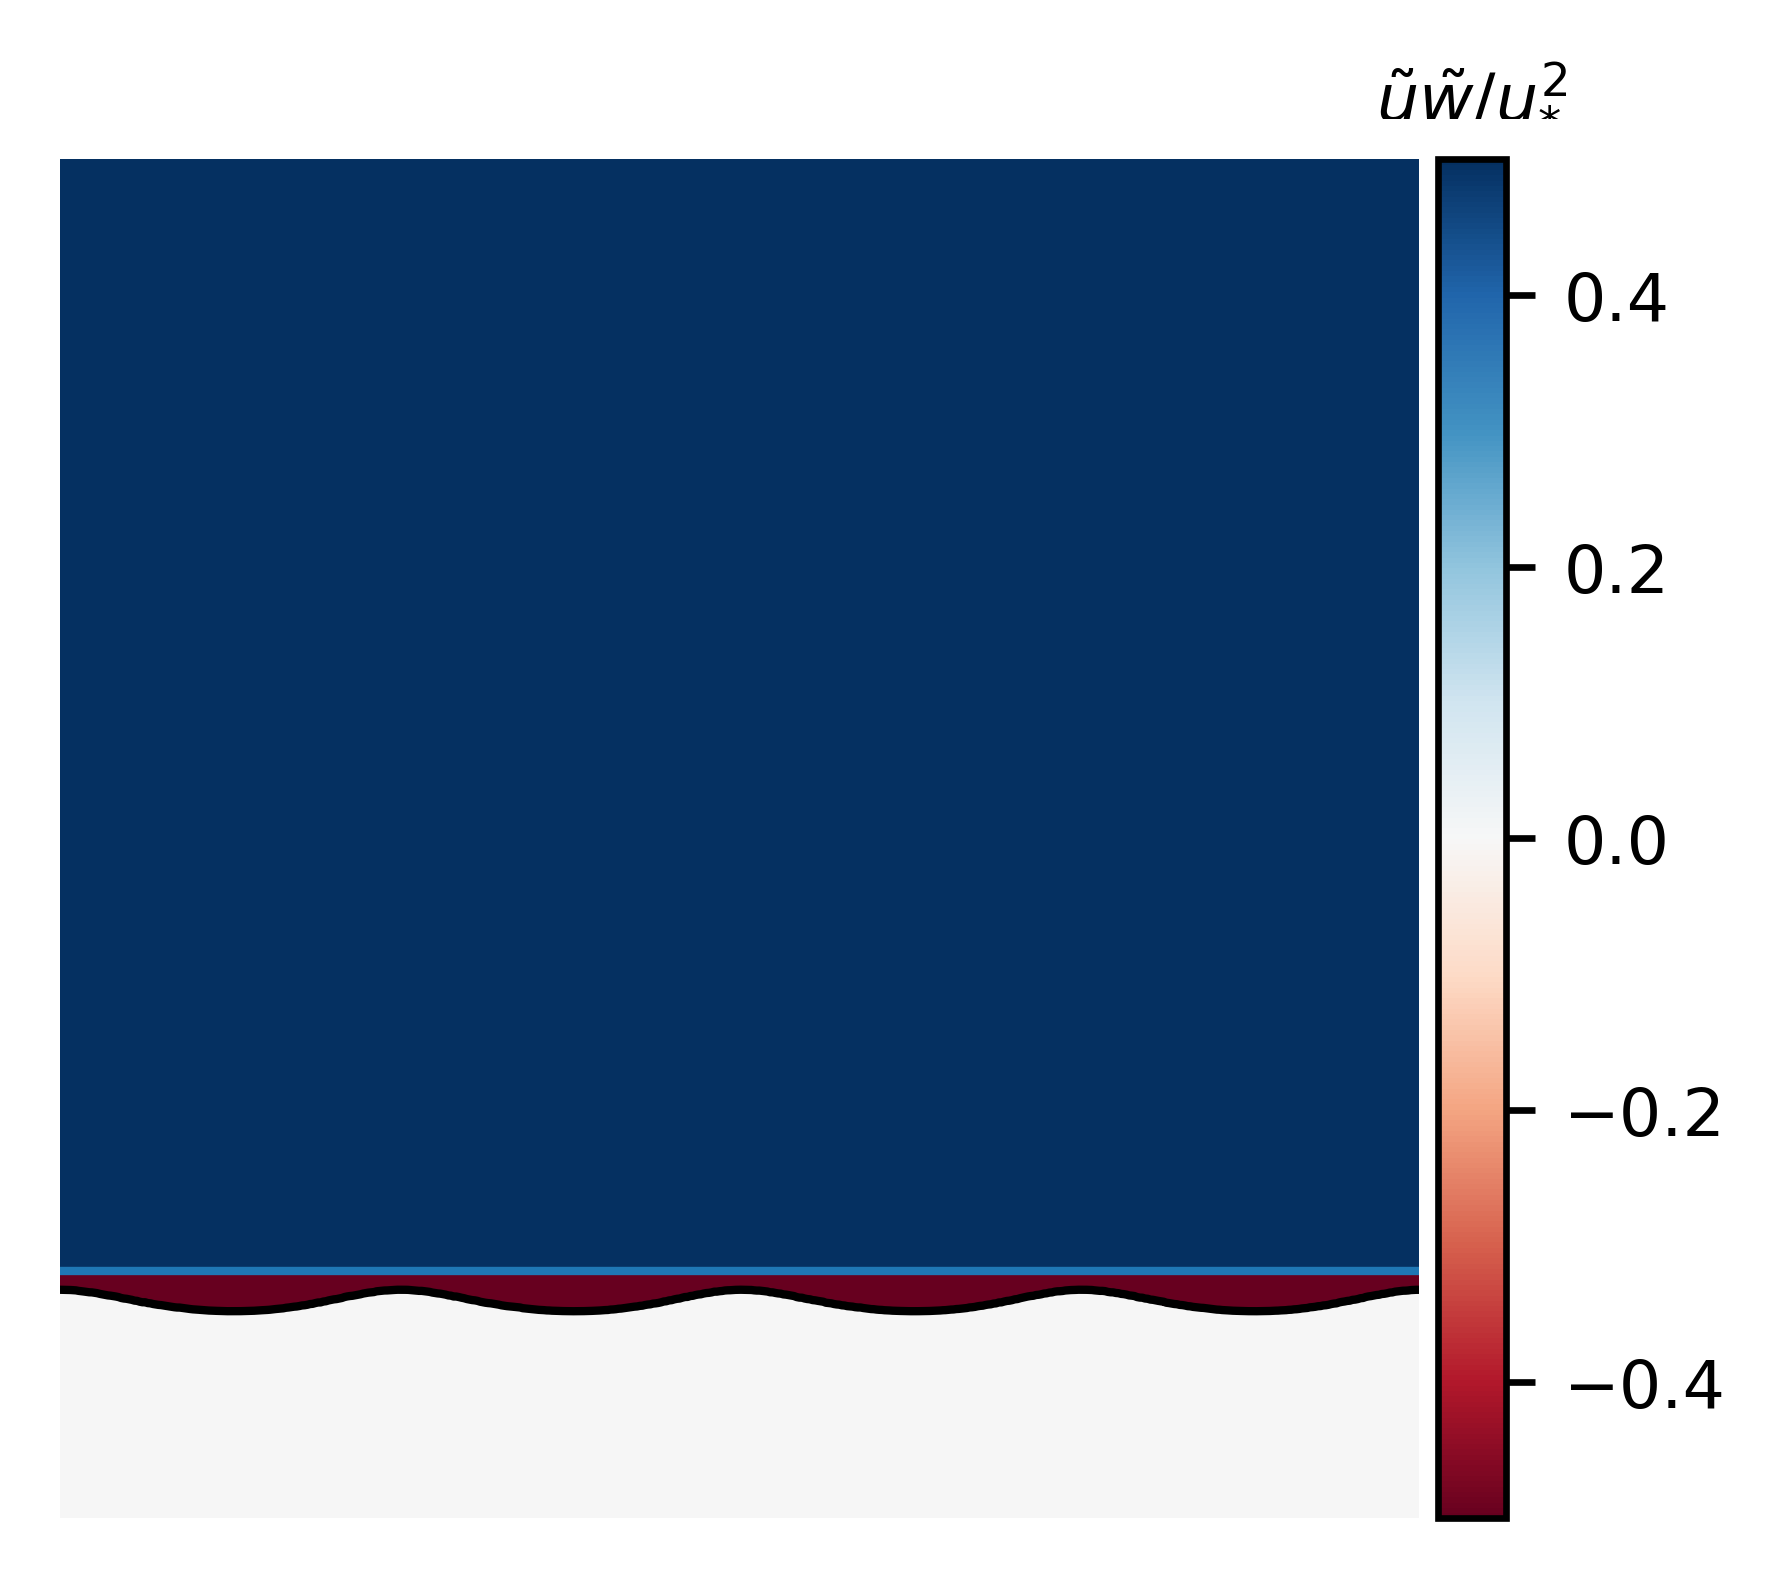

In [65]:
""" Some visualization """
fig = plt.figure(figsize=[4,3])
# quant = (case.uy_2D_phaseaver-case.uy_2D_horizaver)*(case.ux_2D_phaseaver-case.ux_2D_horizaver)/0.25**2*case.f_2D[0] # The quantity to be plotted
quant = (case.ux_2D_horizaver-case.wave.c)/0.25*(1-case.f_2D[0]) # The quantity to be plotted
# quant = (case.uxuy_2D_phaseaver-case.uxuy_2D_horizaver)/0.25**2

img = plt.imshow(np.rot90(quant), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = +0.5, vmin = -0.5)
xarray = np.linspace(-np.pi, np.pi, 512)
eta = np.roll(np.average(case.phase['eta'][0], axis=0), -case.phase['idx'][0], axis=0)
plt.plot(xarray, eta, c='k', lw=1)

cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\tilde{u}\tilde{w}/u_{*}^2$', ha='center', va='center', transform=cbar.ax.transAxes)

In [ ]:
""" Plot the 1D profile along z
    Link with the two scales yk nad y/ytau 
"""

plt.figure(figsize=[4,7.5])

""" Stress quantities. """
ax1 = plt.subplot(311)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel(r"$\tau/\rho_a u_*^2$")

def plot_stress (case, color):
    quant1 = -(case.uy_2D_phaseaver-case.uy_2D_horizaver)*(case.ux_2D_phaseaver-case.ux_2D_horizaver)/0.25**2*case.f_2D[0]
    plt.plot((case.yarray-1)/case.ytau, np.average(quant1, axis=0), color=color)
    # quant = (case.uxuy_2D_phaseaver-case.uxuy_2D_horizaver)/0.25**2 # This averages to zero
    quant2 = -case.uxuy_2D_horizaver/0.25**2
    plt.plot((case.yarray-1)/case.ytau, np.average(quant2, axis=0), '--', color=color)
#     plt.plot((case.yarray-1)/case.ytau, np.average(quant1+quant2, axis=0), ':', color=color)

for (case, color) in zip((case1,case2,case3),('magenta','darkviolet','blue')):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2
    case.ytau = (2*np.pi-1)/case.Retau
    plot_stress(case, color)
# for (case, color) in zip((case4,case5,case6),('magenta','darkviolet','blue')):
#     case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2
#     case.ytau = (2*np.pi-1)/case.Retau
#     plot_stress(case, color)

""" Flow field quantities. """

def plot_velocity (case, color, range1, range2):
    """ Plot velocity and two time scales Te and Ta. """
    plt.plot((case.yarray-1)/case.ytau, (np.average(case.ux_2D_horizaver, axis=0) - case.wave.c)/0.25, 
              marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
              color=color, label=r'$c/u_* = %.0f$' %(case.wave.c/case.ustar))
    plt.plot((case.yarray[range1:range2:2]-1)/case.ytau, (case.yarray[range1:range2:2]-1)/case.ustar*np.pi/0.41, color='gray', alpha=0.5) # T_e = (\pi/\kappa)y/u_*
    plt.plot((case.yarray[range1:range2:2]-1)/case.ytau, (case.yarray[range1:range2:2]-1)/case.ustar, color='gray', alpha=0.5) # Alternative def of T_e = y/\bar{u}(y)
    plt.plot((case.yarray[range1:range2]-1)/case.ytau, 2*np.pi/((np.average(case.ux_2D_horizaver, axis=0)[range1:range2]-case.wave.c)*case.k), color=color, alpha=0.5) # T_a = \lambda/(\bar{u}(y)-c)
    plt.ylim([-2, 23])
    
def plot_gradient (case, color, range1, range2):
    """ Plot the gradient of the meant, required to compute medium layer height.
        Also helps to compute viscous stress. """
    plt.plot((case.yarray-1)/case.ytau, (np.average(case.ux_2D_horizaver, axis=0))/0.25, 
              marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
              color=color, label=r'$c/u_* = %.0f$' %(case.wave.c/case.ustar))
    ux_simu = (np.average(case.ux_2D_horizaver, axis=0))/case.ustar
    ux_smooth = butter_lowpass_filter(ux_simu[range1:range2], CUT=32, N=512)
    # plt.plot((case.yarray[start:-1]-1)/ytau, ux_simu)
    plt.plot((case.yarray[range1:range2]-1)/case.ytau, ux_smooth, color=color, alpha=0.5)
    quant = np.gradient(ux_smooth)/(case.L0/case.N)/(ux_smooth-case.wave.c)/case.k 
    plt.plot((case.yarray[range1:range2]-1)/case.ytau, quant, '--', color=color, alpha = 0.5) # r'$|U(y)^{\prime}/kU||$'
    plt.plot((case.yarray[range1:range2]-1)/case.ytau, (case.yarray[range1:range2]-1)*case.k/case.ustar, color='gray', alpha=0.5) # r'$ky$'

ax2 = plt.subplot(312, sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
for (case, color, range1) in zip((case1,case2,case3),('magenta','darkviolet','blue'), (86, 87, 92)):
    plot_velocity(case, color, range1, 620)
# for (case, color, range1) in zip((case4,case5,case6),('magenta','darkviolet','blue'), (86, 87, 92)):
#     plot_velocity(case, color, range1, 620)
ax2.set_ylabel(r'$(U-c)/u_*$')
ax2.set_ylim([-6, 21])
    
ax3 = plt.subplot(313, sharex=ax1)
for (case, color, range1) in zip((case1,case2,case3),('magenta','darkviolet','blue'), (82, 82, 82)):
    plot_gradient(case, color, range1, 400)
# for (case, color, range1) in zip((case4,case5,case6),('magenta','darkviolet','blue'), (82, 82, 83)):
#     plot_gradient(case, color, range1, 400)
ax3.set_ylabel(r'$U$')
ax3.set_ylim([-1, 26])

""" TODO: Miles' quantities """

""" Roughness length"""
y = np.arange(0.01,400)
plt.plot(y, 1/0.4*np.log(y)+1, color='green', alpha=0.5)
ax.annotate(r'$z_0$', xy=(0.2,0.05), ha='left', va='top', xycoords='axes fraction', color='green')

""" Formatting the axes. """
# plt.xscale('log')
plt.xlim([0.5, 690])
ax3.annotate(r'$y/y_{\nu}$', xy=(1, 0), ha='left', va='top', xycoords='axes fraction')
ax3.set_ylabel(r'$U/u_*$') 
# plt.legend(loc='upper left')

def forward(x):
    return x*case.ytau*case.k
def back(x):
    return x/case.k/case.ytau

secax_x2 = ax3.secondary_xaxis(-0.12, functions=(forward, back))
ax3.annotate(r'$yk$', xy=(1, -0.12), ha='left', va='top', xycoords='axes fraction')

plt.subplots_adjust(wspace=0, hspace=0.05)
ax2.legend(loc='upper left')

In [206]:
2*np.pi/102646

6.121217882021303e-05